In [91]:
#market-price 데이터세의 기본 정보 구하기 
%matplotlib inline 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime

data = "https://raw.githubusercontent.com/annsyj94/Data_Analysis_Project/main/Bitcoin_Prediction/market-price.csv"
df_bitcoin = pd.read_csv(data)

print(df_bitcoin.shape)
print(df_bitcoin.info())
df_bitcoin.tail()

(366, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Timestamp     366 non-null    object 
 1   market-price  366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


,Timestamp,market-price
361,2021-12-21 00:00:00,46910.13
362,2021-12-22 00:00:00,48934.57
363,2021-12-23 00:00:00,48628.35
364,2021-12-24 00:00:00,50785.69
365,2021-12-25 00:00:00,50814.92


In [92]:
# DataFrame로 열 이름 바꾸기 
bitcoin = pd.DataFrame({
    
    "day":df_bitcoin['Timestamp'],
    "price":df_bitcoin['market-price']
})

bitcoin.head(3)

,day,price
0,2020-12-25 00:00:00,23715.53
1,2020-12-26 00:00:00,24693.58
2,2020-12-27 00:00:00,26443.21


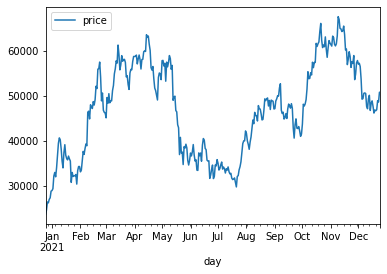

In [93]:
#to_datetime으로 day 피처를 시계열 피처로 변환
bitcoin['day'] = pd.to_datetime(bitcoin['day'])

#day 데이터 프레임의 index로 설정 
bitcoin.index = bitcoin['day']
bitcoin.set_index('day',inplace=True)

#일차별 비트코인 시세 시각함 
bitcoin.plot()
plt.show()

In [94]:
import statsmodels.api as sm 
from statsmodels.tsa.arima_model import ARIMA

#(AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델로 학습 
model = ARIMA (bitcoin.price.values, order = (2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3275.583
Method:                       css-mle   S.D. of innovations           1901.863
Date:                Sun, 26 Dec 2021   AIC                           6563.166
Time:                        07:55:47   BIC                           6586.565
Sample:                             1   HQIC                          6572.465
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.6148     99.670      0.739      0.461    -121.735     268.965
ar.L1.D.y      0.9187      0.019     49.350      0.000       0.882       0.955
ar.L2.D.y     -0.9612      0.019    -51.517      0.0

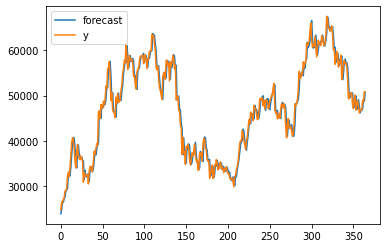

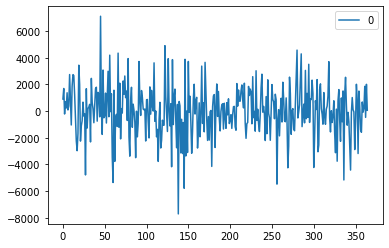

In [95]:
fig = model_fit.plot_predict()#학습 데이터에 대한 예측 결과 (첫 번째 그래프)
residuals = pd.DataFrame(model_fit.resid) #잔차의 변동을 시각 (두 번째 그래프 )

residuals.plot()

In [96]:
#Facebook Prophet 활용하기 
from fbprophet import Prophet 

file = pd.read_csv(data)

#prophet을 사용하기 위해서는 다음과 같이 피처명을 변경해야 합: 'ds','y'
bitcoin_df = pd.DataFrame ({
    "ds":file['Timestamp'],
    "y":file['market-price']
})

model = Prophet(seasonality_mode = "multiplicative",
                yearly_seasonality=True,
                weekly_seasonality=True, daily_seasonality=True,
                changepoint_prior_scale=0.5)

model.fit(bitcoin_df)

In [97]:
#5일을 내다보며 예측합니다. 

future_data= model.make_future_dataframe(periods=5, freq='d')
forecast_data = model.predict(future_data)
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
366,2021-12-26,51217.012797,49003.959584,53613.453159
367,2021-12-27,51904.879989,49588.510644,54431.475571
368,2021-12-28,52752.021633,50248.971232,55056.708102
369,2021-12-29,53327.971784,50709.428456,55938.836815
370,2021-12-30,54180.123832,51614.168952,57045.372302


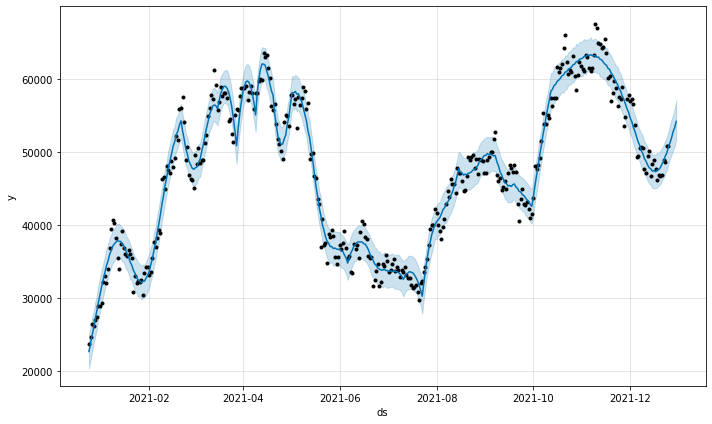

In [98]:
fig1= model.plot(forecast_data)

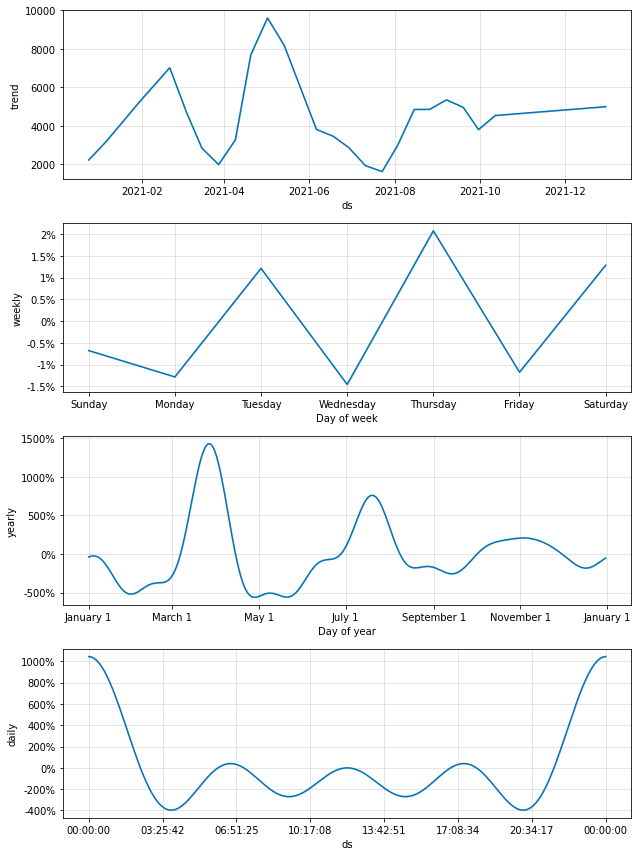

In [99]:
fig2 = model.plot_components(forecast_data)

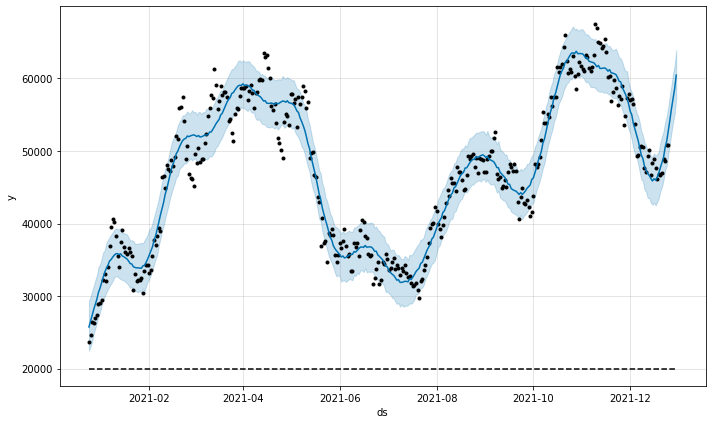

In [100]:
#상한가 및 하한가 설정하기 

#상한가 설정합니다 
bitcoin_df['cap'] = 20000

#상한가 적용을 위한 파라미터를 다음과 같이 설정 
prophet = Prophet(seasonality_mode ="multiplicative",
                  growth = 'logistic',
                  yearly_seasonality=True,
                  weekly_seasonality = True, daily_seasonality = True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

#5일을 내다보며 예측 
future_data = prophet.make_future_dataframe(periods=5,freq='d')

#상한가를 설정 
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)